In [1]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [2]:
import numpy as np
import scipy.io as sio

In [4]:
df = sio.loadmat('snelson1d.mat')
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [6]:
def kmm_init(X, m = 20):
    """
    This is the same initialization algorithm that is used
    in Kmeans++. It's quite simple and very useful to initialize
    the locations of the inducing points in sparse GPs.
    
    http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf
    1. Take one center c1, initially chosen at random
    2. Take a new center ci with prob. \frac{D(x)^2}{\sum D(x)^2}
    3. Repeat step 2 until we have K centers.
    4. Proceed with standard K-means clustering..
    
    where D(x) is the distance to the closest cluster center. 
    If we dont want to invest time on that, just use the initialisation which is good enough atleast for the 1D case.
    
    :param X: data
    :param m: number of inducing points
    """

    # compute the distances
    XXT = np.dot(X, X.T)
    D = (-2.*XXT + np.diag(XXT)[:,np.newaxis] + np.diag(XXT)[np.newaxis,:])

    # select the first point
    s = np.random.permutation(X.shape[0])[0]
    inducing = [s]
    prob = D[s]/D[s].sum()

    for z in range(m-1):
        s = np.random.multinomial(1, prob.flatten()).argmax()
        inducing.append(s)
        prob = D[s]/D[s].sum()

    inducing = np.array(inducing)
    return X[inducing]

In [7]:
X_u = kmm_init(X)
M = len(X_u)

In [8]:
X_u_noisy = np.linspace(0,6, M)[:, None]
X_u_noisy = X_u + 0.1*np.random.rand(*X_u.shape) 

### Code

In [10]:
stan_code_dtc ="""
data {
    int<lower=1> N;
    int<lower=1> M;
    real x[N];
    vector[N] y;
    real xu[M];

}
transformed data {
    real delta = 1e-6;
#     real rho = 1;
#     real alpha = 1;

}
parameters {
    vector[N] f;
    
    real<lower=1e-6> sigma;
    real <lower=1e-4> alpha;
    real<lower=1e-4> rho;
    
    vector[M] eta2;
}

model {

    vector[N] f_mean;
    matrix[N, N] f_cov;
        
     {
        matrix[M, M] L_U;
        matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
        matrix[N, M] Kfu = cov_exp_quad(x, xu, alpha, rho);
        matrix[N, N] K = cov_exp_quad(x, alpha, rho);
        vector[M] Kuu_inv_u;
        matrix[M, N] v_pred;
        vector[M] u;
        
        for (m in 1:M)
            Kuu[m, m] = Kuu[m, m] + delta;
                    
        L_U = cholesky_decompose(Kuu);
        u = L_U * eta2;
        
        // f_mean = Kfu*(Kuu_inv*u) = Kfu * inv(LL')u = Kfu * inv(L') *inv(L) * L * eta = = Kfu * inv(L') * eta;        
        Kuu_inv_u = mdivide_left_tri_low(L_U, eta2);
        f_mean = Kfu*Kuu_inv_u;
        
        // f_cov = K - Kfu*(Kuu_inv*Kfu');            
        v_pred = mdivide_left_tri_low(L_U, Kfu');
        f_cov = diag_matrix(rep_vector(delta,N));
    }
  
#     rho ~ inv_gamma(5, 5);
#     alpha ~ normal(0, 1);
    
    rho ~ normal(1.33, 0.15);
    alpha ~ normal(0.9, 0.2);
    sigma ~ normal(0, 0.35);
    eta2 ~ normal(0, 1);
    f ~ multi_normal(f_mean, f_cov);
    y ~ normal(f, sigma);
}

"""


In [13]:
stan_model_dtc = pystan.StanModel(model_code=stan_code_dtc)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_12e14653aa29f09b4da7ec559b662fe4 NOW.


In [36]:
gp_reg_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':20, 'xu':X_u_noisy.flatten()}

In [15]:
fit_dtc = stan_model_dtc.sampling(data=gp_reg_data, iter=1000, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [1]:
print(fit_dtc)

In [2]:
samples_dtc = fit_dtc.extract(permuted=True)
f = samples_dtc['f']
f_mean = np.mean(f, axis=0)

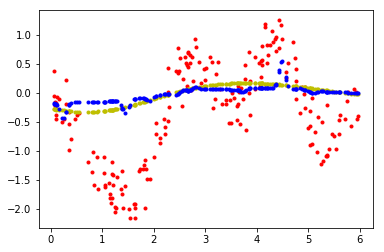

In [24]:
sort_idx = np.argsort(X.ravel())

plt.plot(X[sort_idx], Y[sort_idx], 'r.')
plt.plot(X[sort_idx], f[-1, sort_idx], 'y.');
# plt.plot(X[sort_idx], f[-100, sort_idx], 'g.');
plt.plot(X[sort_idx], f_mean[sort_idx], 'b.');
# plt.plot(X[sort_idx], sigma[-1, sort_idx], 'b.');

(600, 20)


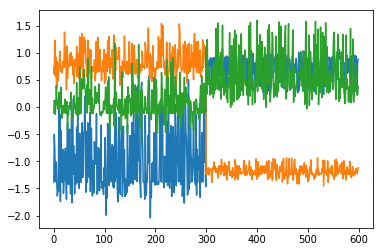

In [29]:
eta = samples['eta2']
print(eta.shape)
plt.plot(eta[:, 0])
plt.plot(eta[:, 1])
plt.plot(eta[:, 2])

In [50]:

samples_dtc = fit_dtc.extract(permuted=True)
f = samples_dtc['f']
f_mean = np.mean(f, axis=0)
sigma = samples_dtc['sigma']
sigma_mean = np.mean(sigma, axis=0)

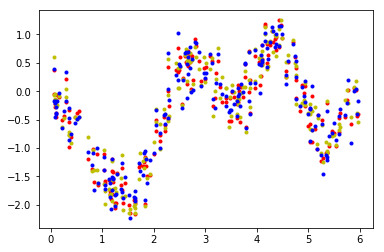

In [52]:
sort_idx = np.argsort(X.ravel())

plt.plot(X[sort_idx], Y[sort_idx], 'r.')
plt.plot(X[sort_idx], f[-1, sort_idx], 'y.');
plt.plot(X[sort_idx], f[-20, sort_idx], 'b.');
plt.plot(X[sort_idx], f[-40, sort_idx], 'g.');


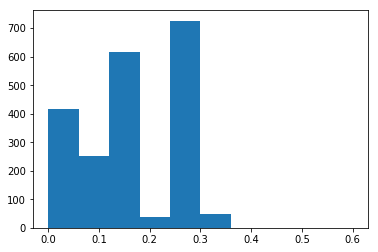

In [58]:
plt.hist(sigma, range=[0, 0.6]);

In [62]:
sigma_mean = np.mean(samples_dtc['sigma'])
sigma_median = np.nanmedian(samples_fitc['sigma'])

l_mean = np.mean(samples_dtc['rho'])
l_median = np.nanmedian(samples_dtc['rho'])

sigvar_mean = np.mean(samples_dtc['alpha'])
sigvar_median = np.nanmedian(samples_dtc['alpha'])

print("mean of noise variance: %.2f" % sigma_mean)
print("median of noise variance: %.2f"% sigma_median)
print("mean of lengthscale: %.3f"% l_mean)
print("median of lengthscale: %.3f"% l_median)
print("mean of signal variance: %.3f"% sigvar_mean)
print("median of signal variance: %.3f"% sigvar_median)

0.7080905589358755
0.2575391868400646


(2800, 20)


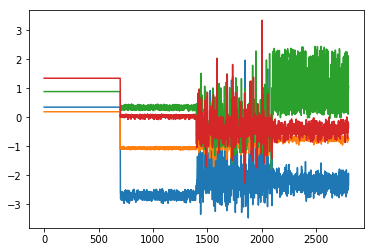

In [64]:
eta_fitc = samples_dtc['eta2']
plt.plot(eta_dtc[:, 0])
plt.plot(eta_dtc[:, 1])
plt.plot(eta_dtc[:, 2])
plt.plot(eta_dtc[:, 5])